In [1]:
import numpy as np

import torch
import torch.nn as nn

import torch.optim as optim
from torch.autograd import Variable

In [2]:
vocab = ["I like drinking coffee", "I love watching cricket", "I hate talking back", "We are going out"]

In [3]:
word_list = " ".join(vocab).split()
word_list = list(set(word_list))
word_list

['hate',
 'going',
 'out',
 'are',
 'like',
 'We',
 'back',
 'coffee',
 'watching',
 'drinking',
 'cricket',
 'love',
 'talking',
 'I']

In [4]:
word_dict = {w:i  for i,w in enumerate(word_list)}
word_dict

{'hate': 0,
 'going': 1,
 'out': 2,
 'are': 3,
 'like': 4,
 'We': 5,
 'back': 6,
 'coffee': 7,
 'watching': 8,
 'drinking': 9,
 'cricket': 10,
 'love': 11,
 'talking': 12,
 'I': 13}

In [5]:
number_dict = {i:w for i,w in enumerate(word_list)}
number_dict

{0: 'hate',
 1: 'going',
 2: 'out',
 3: 'are',
 4: 'like',
 5: 'We',
 6: 'back',
 7: 'coffee',
 8: 'watching',
 9: 'drinking',
 10: 'cricket',
 11: 'love',
 12: 'talking',
 13: 'I'}

In [6]:
def make_batch(sentences):
    input_batch = []
    target_batch = []
    
    for sen in sentences:
        word = sen.split()
        input = [word_dict[n] for n in word[:-1]] # all words expect the last
        target = word_dict[word[-1]] # last word
        
        input_batch.append(input)
        target_batch.append(target)
    return input_batch, target_batch

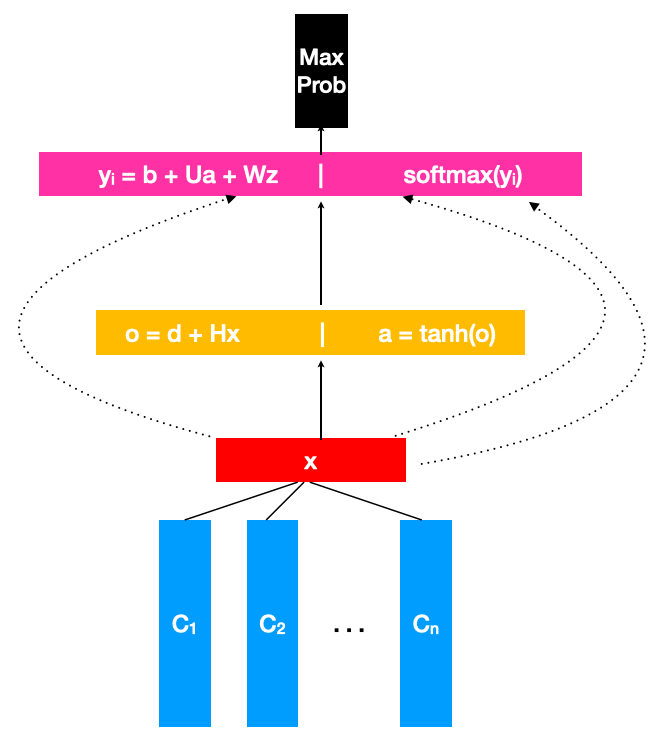

x is the word features layer activation vector which is the concatenation of input word features C

o = d + Hx        |         a = tanh(o)

y_i = b + Wx + Ua

=> y_i = b + Wx + U tanh(d + Hx)



* y_i = un-normalised log-probabilities for each output i
* b    = bias : (|V| elements)
* W    = word features to output : (|V| x (n-1)m)
* x    = word feature
* h    = number of hidden units
* m    = number of features associated with each word
* d    = hidden layer bias: (h elements)
* U    = hidden to output weights : (|V| x h)
* H    = hidden layer weights : (h x (n-1)m))
* C    = Word features : (|V| x m)

So the parameters are = b, d, W, U, H, C

In [7]:
n_class = len(word_dict)
n_class

14

In [8]:
# Neural Language Model parameters
n_step = 3
n_hidden = 2
m = 2

In [12]:
dtype = torch.FloatTensor

In [13]:
# MOdEl
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # [num_of_classes x num_of_features_for_each_word]
        self.C = nn.Embedding(n_class, m) 
        # [num_of_input_words(num_of_features_for_each_word) x num_of_hidden_units]
        self.H = nn.Parameter(torch.randn(n_step *m, n_hidden).type(dtype))
        # [num_of_input_words(num_of_features_for_each_word) x num_of_classes]
        self.W = nn.Parameter(torch.randn(n_step *m, n_class).type(dtype))  
        # [num_of_hidden_units ]
        self.d = nn.Parameter(torch.randn(n_hidden).type(dtype))
        # [num_of_classes ]
        self.b = nn.Parameter(torch.randn(n_class).type(dtype))
        # [num_of_hidden_units x num_of_classes ]
        self.U = nn.Parameter(torch.randn(n_hidden, n_class).type(dtype))
        
    def forward(self, x):
        x = self.C(x)
        x = x.view(-1, n_step * m)
        tanh = torch.tanh(self.d + torch.mm(x, self.H))
        output = self.b + torch.mm(x, self.W) + torch.mm(tanh, self.U)
        return output

In [14]:
model = Network()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [15]:
input_batch, target_batch = make_batch(vocab)

input_batch = Variable(torch.LongTensor(input_batch))
target_batch = Variable(torch.LongTensor(target_batch))

In [16]:
epochs = 500
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    output = model(input_batch)
    
    loss = criterion(output, target_batch)
    if epoch%50 == 0:
        print(f"epoch: {epoch} ===> loss: {loss}")
        

    loss.backward()
    optimizer.step()

epoch: 50 ===> loss: 0.6894525289535522
epoch: 100 ===> loss: 0.06595111638307571
epoch: 150 ===> loss: 0.0259373988956213
epoch: 200 ===> loss: 0.014910985715687275
epoch: 250 ===> loss: 0.009892888367176056
epoch: 300 ===> loss: 0.007118134293705225
epoch: 350 ===> loss: 0.005401680711656809
epoch: 400 ===> loss: 0.004257441498339176
epoch: 450 ===> loss: 0.003452293574810028
epoch: 500 ===> loss: 0.0028621088713407516


In [17]:
predict = model(input_batch).data.max(1, keepdim=True)[1]
predict

tensor([[ 7],
        [10],
        [ 6],
        [ 2]])

In [39]:
f_in = []
for sen in vocab:
    word = sen.split()
    f_in.append([n for n in word[:-1]])

In [40]:
f_out = []
for index in predict:
    f_out.append(number_dict[index.item()])

In [42]:
for i in range(len(f_in)):
    print(f_in[i]," ==> ", f_out[i])

['I', 'like', 'drinking']  ==>  coffee
['I', 'love', 'watching']  ==>  cricket
['I', 'hate', 'talking']  ==>  back
['We', 'are', 'going']  ==>  out
